In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [96]:
import itertools, glob, sys

import catboost as cb

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
from utils.visualize import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [97]:
cols_to_drop = [
    "days_with_fog",
    "direction_max_wind_speed",
    "direction_peak_wind_speed",
    "max_wind_speed",
    "facility_type",
]

feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area", "elevation"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area", "elevation"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area", "elevation"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_all_env_pca_onehot": {
        "cols_to_reduce": list(
            set(temp_col_list + days_col_list + inch_col_list + wind_col_list)
            - set(cols_to_drop)
        ),
        "log10_transform_cols": ["floor_area", "elevation"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_all_env_pca_onehot_impute": {
        "cols_to_reduce": list(
            set(temp_col_list + days_col_list + inch_col_list + wind_col_list)
            - set(cols_to_drop)
        ),
        "log10_transform_cols": ["floor_area", "elevation"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": [
                "state_factor",
                "building_class",
                "facility_type_parsed",
            ]
        },
    },
    "log_temp_pca_cat": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "log_temp_precip_pca_onehot": {
        "cols_to_reduce": temp_col_list + inch_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
}


# Define which function to run
run_model_dict = {
    "sklearn": mu.run_sklearn_model,
    "catboost": mu.run_catboost_model,
    "lightgbm": mu.run_lgb_model,
    "dnn": mu.run_dnn_model,
}

NameError: name 'mu' is not defined

<IPython.core.display.Javascript object>

In [152]:
def combine_rmse_results(config_name_list, depth_list=[6, 8, 10, 12], seed_list=[0, 9]):
    rmse_df = pd.DataFrame()
    for config_name in config_name_list:
        for seed, depth in itertools.product(seed_list, depth_list):
            #             print(seed, depth, config_name)
            try:
                _df = pd.read_csv(
                    f"{wids_path}/validation_result/diana/{config_name}_depth{depth}_seed{seed}.csv"
                ).assign(config=config_name, depth=depth, seed=seed)
                rmse_df = pd.concat([rmse_df, _df], axis=0)
            except:
                print(f"{config_name}_depth{depth}_seed{seed}.csv not found")
        rmse_df = rmse_df.reset_index(drop=True)
    return rmse_df


def combine_rmse_results_from_dir(dir_name, prefix=""):
    rmse_df = pd.DataFrame()
    all_files = glob.glob(
        f"{dir_name}/{prefix}*.csv"
    )  # glob.glob(f"{dir_name}/dnn*.csv") + glob.glob(f"{dir_name}/cat*.csv")
    #     all_files = pd.DataFrame()
    all_files = pd.Series(all_files)[~pd.Series(all_files).str.contains("seed")]
    for f in all_files:
        config_name = f.replace(f"{dir_name}/", "").replace(".csv", "")
        try:
            print(f"Loading {f}")
            _df = pd.read_csv(f).assign(config=config_name, seed=0)
            rmse_df = pd.concat([rmse_df, _df], axis=0)
        except:
            print(f"{f} not found/loaded")
    rmse_df = rmse_df.reset_index(drop=True)
    return all_files, rmse_df

<IPython.core.display.Javascript object>

In [153]:
# rmse_df = combine_rmse_results(feature_dict.keys())
all_files, rmse_df = combine_rmse_results_from_dir(
    "/Users/diana/Documents/projects/widsdatathon2022/validation_result/diana", "log"
)
rmse_df

Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_allenvpca_parse_upsample_impute_catboost.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_allenvpca_parse_upsample_catboost.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_temppca_parse_upsample_impute_lightgbm.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_allenvpca_parse_upsample_lightgbm.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_allenvpca_parse_upsample_impute_lightgbm.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_allenvpca_parse_upsample_impute_dnn.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_result/diana/log_onehot_temppca_parse_upsample_impute_dnn.csv
Loading /Users/diana/Documents/projects/widsdatathon2022/validation_r

,left_out_year,train_rmse,test_rmse,method,config,seed
0,1.0,14.924202,54.724094,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
1,2.0,15.035792,44.171976,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
2,3.0,14.039699,47.953138,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
3,4.0,14.789062,37.575783,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
4,5.0,14.746464,35.543938,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
5,6.0,14.893109,44.153213,loyo,log_onehot_allenvpca_parse_upsample_impute_cat...,0
6,0.0,15.021666,NaN,whole train,log_onehot_allenvpca_parse_upsample_impute_cat...,0
7,1.0,14.625645,55.876541,loyo,log_onehot_allenvpca_parse_upsample_catboost,0
8,2.0,14.576456,43.402390,loyo,log_onehot_allenvpca_parse_upsample_catboost,0
9,3.0,13.685029,48.658314,loyo,log_onehot_allenvpca_parse_upsample_catboost,0


<IPython.core.display.Javascript object>

In [154]:
all_files

2     /Users/diana/Documents/projects/widsdatathon20...
8     /Users/diana/Documents/projects/widsdatathon20...
10    /Users/diana/Documents/projects/widsdatathon20...
15    /Users/diana/Documents/projects/widsdatathon20...
18    /Users/diana/Documents/projects/widsdatathon20...
19    /Users/diana/Documents/projects/widsdatathon20...
24    /Users/diana/Documents/projects/widsdatathon20...
28    /Users/diana/Documents/projects/widsdatathon20...
dtype: object

<IPython.core.display.Javascript object>

In [149]:
def plot_train_and_test_rmse(rmse_df, seed, hue="depth"):
    fig, axes = plt.subplots(figsize=(11, 9), nrows=2)
    sns.boxplot(
        data=rmse_df.query("method == 'loyo' and seed == @seed").sort_values("config"),
        x="config",
        y="train_rmse",
        hue=hue,
        ax=axes[0],
    )
    add_median_labels(axes[0])
    sns.scatterplot(
        data=rmse_df.query("method == 'whole train' and seed == @seed").sort_values(
            "config"
        ),
        x="config",
        y="train_rmse",
        ax=axes[0],
        color="white",
        edgecolor="k",
        label="whole train",
        hue=hue,
    )
    _ = axes[0].set_xticklabels([])
    axes[0].legend(bbox_to_anchor=(1, 1))

    sns.boxplot(
        data=rmse_df.sort_values("config"),
        x="config",
        y="test_rmse",
        hue=hue,
        ax=axes[1],
    )
    _ = axes[1].tick_params(labelrotation=90)
    axes[1].legend(bbox_to_anchor=(1, 1))
    add_median_labels(axes[1])
    fig.subplots_adjust(hspace=0)
    fig.suptitle(f"Seed {seed}")

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


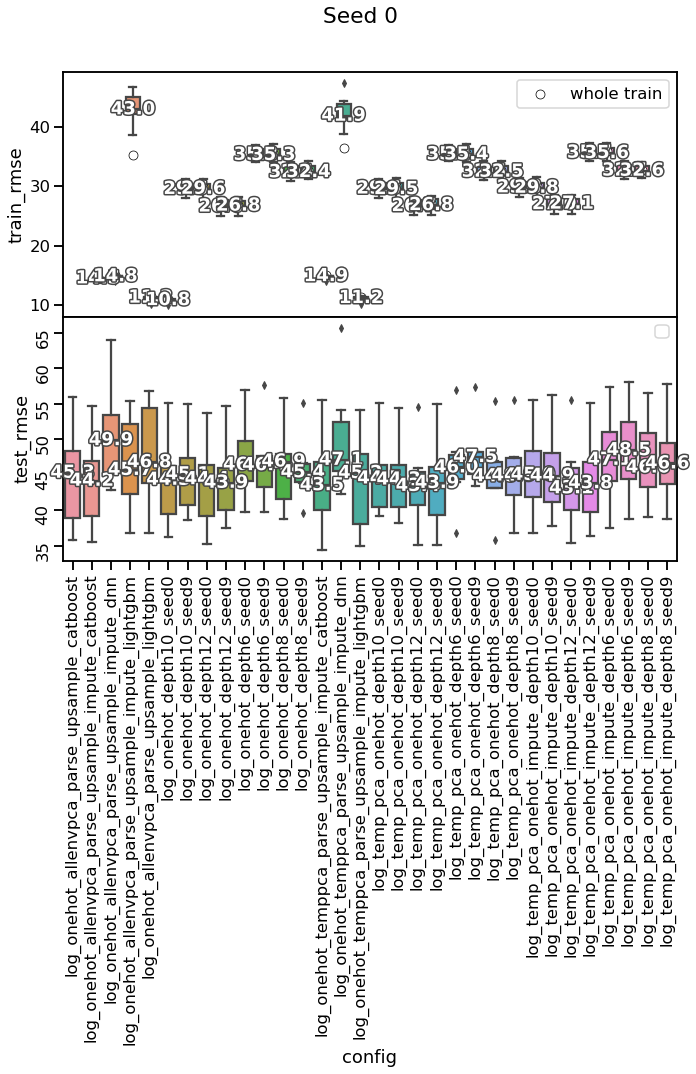

<IPython.core.display.Javascript object>

In [150]:
plot_train_and_test_rmse(rmse_df, 0, hue=None)

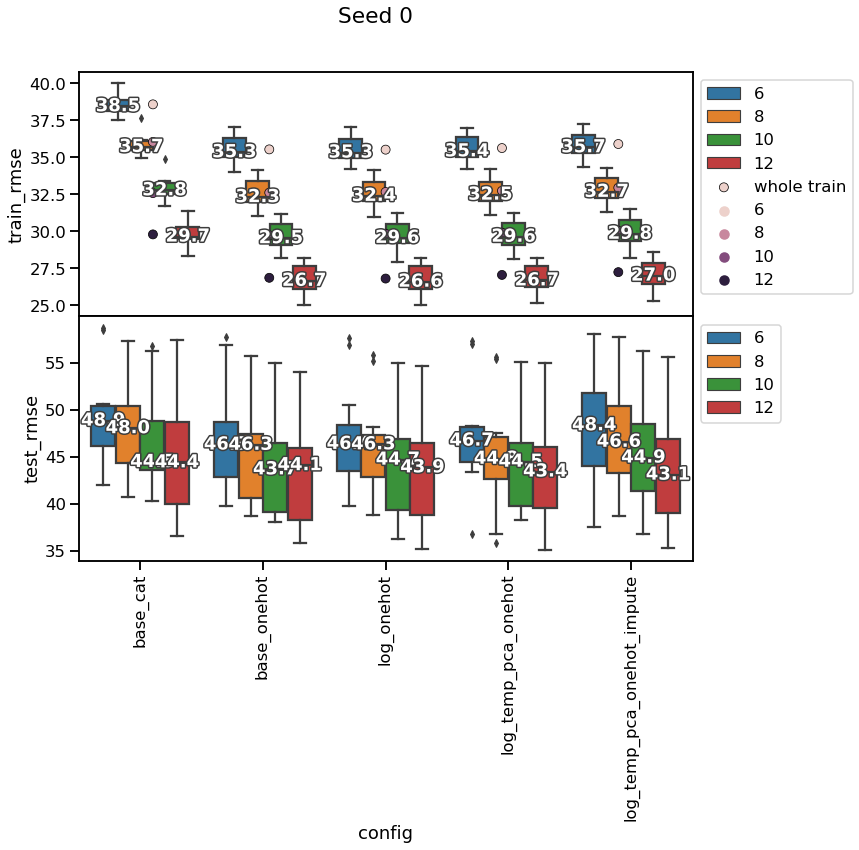

<IPython.core.display.Javascript object>

In [82]:
plot_train_and_test_rmse(rmse_df, 0)

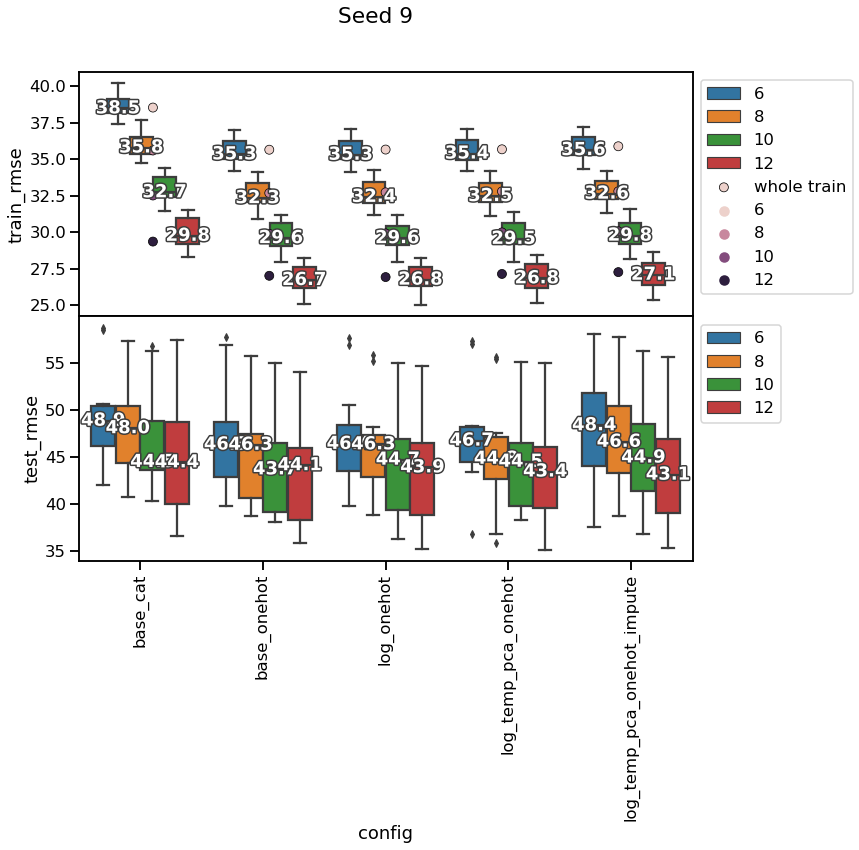

<IPython.core.display.Javascript object>

In [83]:
plot_train_and_test_rmse(rmse_df, 9)

log_temp_pca_onehot
log_temp_pca_onehot
log_temp_pca_onehot
log_temp_pca_onehot


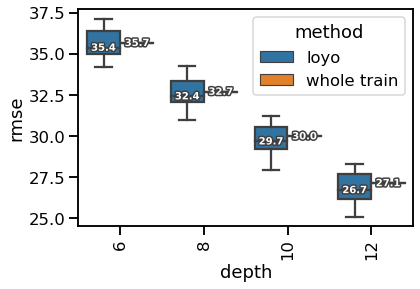

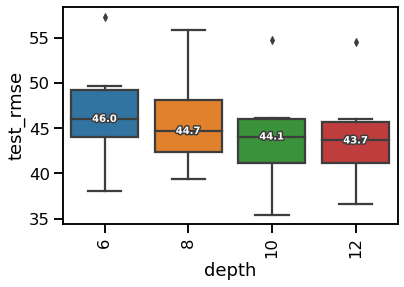

<IPython.core.display.Javascript object>

In [30]:
# Hyper-parameter tuning model performance based on best feature combo
rmse_df = pd.DataFrame()
config_name = "log_temp_pca_onehot"
for depth in [6, 8, 10, 12]:
    print(config_name)
    _df = pd.read_csv(
        f"{wids_path}/validation_result/{config_name}_depth{depth}.csv"
    ).assign(config=config_name, depth=depth)
    rmse_df = pd.concat([rmse_df, _df], axis=0)
rmse_df = rmse_df.reset_index(drop=True)

fig, ax = plt.subplots()
sns.boxplot(
    data=pd.melt(
        rmse_df,
        id_vars=["method", "depth"],
        value_name="rmse",
        value_vars=["train_rmse"],
    ),
    x="depth",
    y="rmse",
    hue="method",
    ax=ax,
)
add_median_labels(ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.figure()
ax = sns.boxplot(data=rmse_df.sort_values("depth"), x="depth", y="test_rmse")
add_median_labels(ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [18]:
rmse_df.query("method == 'whole train'").sort_values("depth")

,left_out_year,train_rmse,test_rmse,method,config,depth
6,0.0,35.655733,NaN,whole train,log_temp_pca_onehot,6
13,0.0,32.694107,NaN,whole train,log_temp_pca_onehot,8
20,0.0,29.987524,NaN,whole train,log_temp_pca_onehot,10
27,0.0,27.141212,NaN,whole train,log_temp_pca_onehot,12


<IPython.core.display.Javascript object>

log_temp_pca_onehot
log_temp_pca_onehot
log_temp_pca_onehot
log_temp_pca_onehot


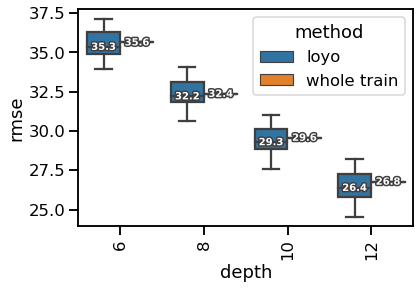

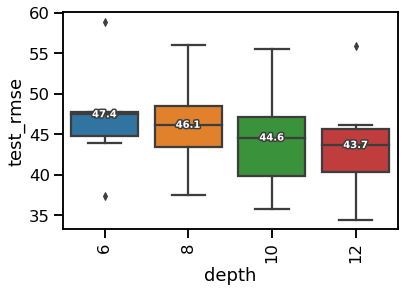

<IPython.core.display.Javascript object>

In [37]:
# Hyper-parameter tuning model performance based on best feature combo
# turning max nan filling
rmse_df = pd.DataFrame()
config_name = "log_temp_pca_onehot"
for depth in [6, 8, 10, 12]:
    print(config_name)
    _df = pd.read_csv(
        f"{wids_path}/validation_result/{config_name}_depth{depth}_maxnan.csv"
    ).assign(config=config_name, depth=depth)
    rmse_df = pd.concat([rmse_df, _df], axis=0)
rmse_df = rmse_df.reset_index(drop=True)

fig, ax = plt.subplots()
sns.boxplot(
    data=pd.melt(
        rmse_df,
        id_vars=["method", "depth"],
        value_name="rmse",
        value_vars=["train_rmse"],
    ),
    x="depth",
    y="rmse",
    hue="method",
    ax=ax,
)
add_median_labels(ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.figure()
ax = sns.boxplot(data=rmse_df.sort_values("depth"), x="depth", y="test_rmse")
add_median_labels(ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)